In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from skimage.transform import ProjectiveTransform, warp

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')

    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')


class PanoramaStitcher:
    def __init__(self):
        self.sift = cv2.SIFT_create()

    def preprocess_images(self, img1, img2):
        """Step 1: Load images and convert to grayscale"""
        self.gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        self.gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        return self.gray1, self.gray2

    def detect_and_describe(self, image):
        """Step 2: Detect keypoints and extract SIFT descriptors"""
        keypoints, descriptors = self.sift.detectAndCompute(image, None)

        # Convert keypoints to numpy array of points
        points = np.float32([kp.pt for kp in keypoints])
        return points, descriptors, keypoints

    def match_features(self, desc1, desc2, threshold=0.7):
        """Step 3: Match features using Euclidean distance"""
        # Compute pairwise distances between all descriptors
        distances = cdist(desc1, desc2, metric='sqeuclidean')

        # Find best and second-best matches for each descriptor
        matches = []
        for i in range(distances.shape[0]):
            sorted_idx = np.argsort(distances[i])
            best_dist = distances[i][sorted_idx[0]]
            second_best_dist = distances[i][sorted_idx[1]]

            # Apply Lowe's ratio test
            if best_dist < threshold * second_best_dist:
                matches.append((i, sorted_idx[0]))

        return np.array(matches)

    def plot_matches(self, img1, img2, points1, points2, matches):
        """Step 4: Plot inlier matches between images"""
        inliers = np.zeros((len(matches), 4))
        for idx, (i, j) in enumerate(matches):
            inliers[idx] = [points1[i][0], points1[i][1],
                           points2[j][0], points2[j][1]]

        fig, ax = plt.subplots(figsize=(20,10))
        plot_inlier_matches(ax, img1, img2, inliers)
        plt.show()
        return inliers

    def ransac_affine(self, points1, points2, matches, num_iterations=1000, threshold=5.0):
        """Step 5: RANSAC for robust affine transformation estimation
        Minimum points needed for affine transform: 3 points"""
        best_inliers = []
        best_transform = None

        for _ in range(num_iterations):
            # Randomly select 3 matches
            rand_indices = np.random.choice(len(matches), 3, replace=False)
            sample_matches = matches[rand_indices]

            # Get corresponding points
            src_pts = np.float32([points1[m[0]] for m in sample_matches])
            dst_pts = np.float32([points2[m[1]] for m in sample_matches])

            # Estimate affine transform
            transform = cv2.estimateAffinePartial2D(src_pts, dst_pts)[0]
            if transform is None:
                continue

            # Count inliers
            inliers = []
            for match in matches:
                src_pt = np.float32(points1[match[0]]).reshape(-1, 1, 2)
                dst_pt = np.float32(points2[match[1]]).reshape(-1, 1, 2)

                transformed_pt = cv2.transform(src_pt, transform)[0,0]
                error = np.linalg.norm(transformed_pt - dst_pt)

                if error < threshold:
                    inliers.append(match)

            if len(inliers) > len(best_inliers):
                best_inliers = inliers
                best_transform = transform

        return best_transform, best_inliers

    def optimal_transform(self, points1, points2, inliers):
        """Step 6: Compute optimal transformation using all inliers"""
        src_pts = np.float32([points1[m[0]] for m in inliers])
        dst_pts = np.float32([points2[m[1]] for m in inliers])

        # Compute optimal affine transform using least squares
        transform = cv2.estimateAffinePartial2D(src_pts, dst_pts)[0]
        return transform

    def create_panorama(self, img1, img2, transform):
        """Step 7: Create the final panorama"""
        # Calculate size of output image
        h1, w1 = img1.shape[:2]
        h2, w2 = img2.shape[:2]

        # Calculate corners of transformed image
        corners = np.array([[0, 0], [w1, 0], [w1, h1], [0, h1]], dtype=np.float32).reshape(-1, 1, 2)
        transformed_corners = cv2.transform(corners, transform).reshape(-1, 2)  # Reshape to 2D

        # Create the corners for the second image
        img2_corners = np.array([[0, 0], [w2, 0], [w2, h2], [0, h2]], dtype=np.float32)

        # Calculate output dimensions
        all_corners = np.vstack((transformed_corners, img2_corners))
        min_x, min_y = np.min(all_corners, axis=0)
        max_x, max_y = np.max(all_corners, axis=0)

        output_shape = (int(max_y - min_y), int(max_x - min_x), 3)

        # Adjust transformation matrix for offset
        transform = np.vstack([transform, [0, 0, 1]])
        offset_transform = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
        final_transform = offset_transform @ transform

        # Warp and combine images
        panorama = np.zeros(output_shape, dtype=np.uint8)
        warped_img1 = cv2.warpPerspective(img1, final_transform, (output_shape[1], output_shape[0]))

        # Copy second image into panorama
        x_offset = int(-min_x)
        y_offset = int(-min_y)
        panorama[y_offset:y_offset+h2, x_offset:x_offset+w2] = img2

        # Combine images by taking maximum value
        mask = (warped_img1 != 0)
        panorama[mask] = np.maximum(panorama[mask], warped_img1[mask])

        return panorama



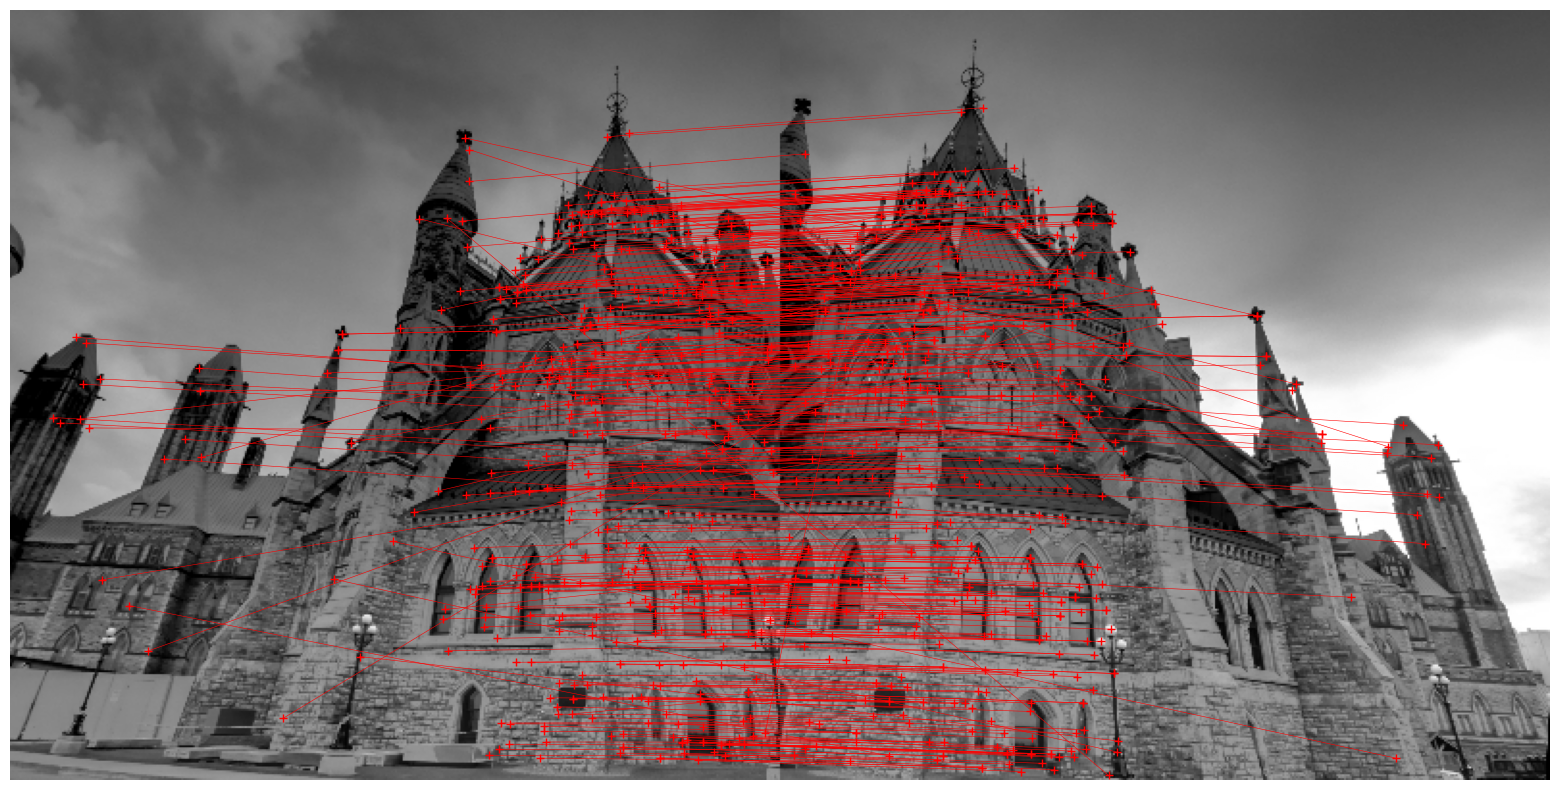

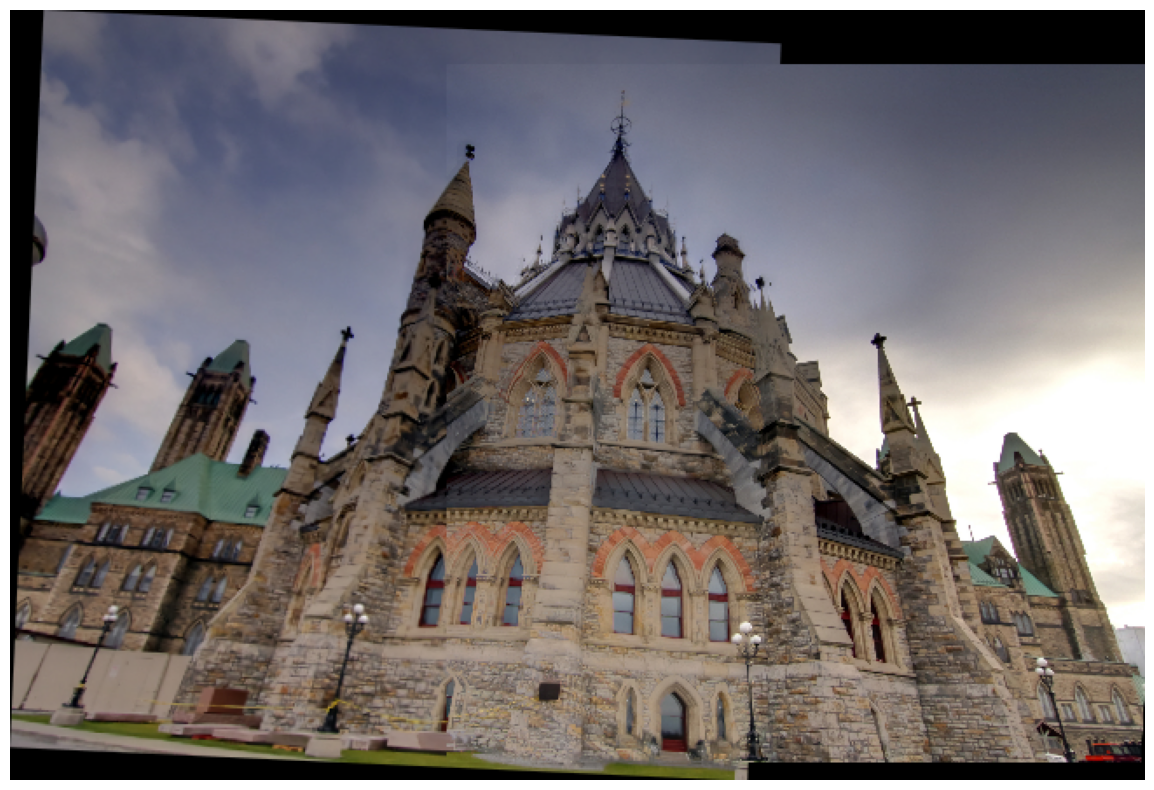

In [17]:
def main(img1_path , img2_path ):
    # Load images
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    fixed_width=400
    fixed_height=400

    # Check if images were successfully loaded
    if img1 is None:
      raise FileNotFoundError(f"Failed to load imageA from {img1_path}")
    if img2 is None:
      raise FileNotFoundError(f"Failed to load imageB from {img2_path}")

    # Resize both images to the same dimensions
    img1 = cv2.resize(img1, (fixed_width, fixed_height))
    img2 = cv2.resize(img2, (fixed_width, fixed_height))

    # Initialize stitcher
    stitcher = PanoramaStitcher()

    # Follow the steps
    gray1, gray2 = stitcher.preprocess_images(img1, img2)

    points1, desc1, kp1 = stitcher.detect_and_describe(gray1)
    points2, desc2, kp2 = stitcher.detect_and_describe(gray2)

    # Display keypoints
    img_kp1 = cv2.drawKeypoints(gray1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img_kp2 = cv2.drawKeypoints(gray2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    matches = stitcher.match_features(desc1, desc2)
    inliers = stitcher.plot_matches(gray1, gray2, points1, points2, matches)

    transform, best_inliers = stitcher.ransac_affine(points1, points2, matches)
    optimal_transform = stitcher.optimal_transform(points1, points2, best_inliers)

    panorama = stitcher.create_panorama(img1, img2, optimal_transform)

    # Display results
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
  img1_path ='/content/drive/MyDrive/image-stitching-using-sift-ransac/left.jpg'
  img2_path ='/content/drive/MyDrive/image-stitching-using-sift-ransac/right.jpg'
  main(img1_path , img2_path)